In [1]:
#run this command to install required libraries
#pip install -r requirements.txt

In [2]:
import pickle
import cProfile
import pstats
import os
from threading import Lock, Thread
from multiprocessing import Process
from queue import Queue

In [3]:
current_directory = os.getcwd()  # Get the current working directory
parent_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
print("Parent Directory:", parent_directory)

Parent Directory: C:\Users\Administrator.DESKTOP-D3SVMI5\Documents\GitHub\PySeirCity-Hybrid-ABM-EBM-Epi-Model


In [4]:
# Load serialized data 
with open(parent_directory+'\\data\\dates.pkl', 'rb') as file:
    dates = pickle.load(file)
    
with open(parent_directory+'\\data\\facility_date_time_step_urbano_agent_dic.pkl', 'rb') as file:
    facility_date_time_step_urbano_agent_dic = pickle.load(file)
with open(parent_directory+'\\data\\urbano_agent_date_time_step_facility_dic.pkl', 'rb') as file:
    urbano_agent_date_time_step_facility_dic = pickle.load(file)
    
with open(parent_directory+'\\data\\urbano_agents_travelers_mapping.pkl', 'rb') as file:
    urbano_agents_travelers_mapping = pickle.load(file)
with open(parent_directory+'\\data\\traveler_urbano_agent_mapping.pkl', 'rb') as file:
    traveler_urbano_agent_mapping = pickle.load(file)
    
with open(parent_directory+'\\data\\time_use_baseline_dict.pkl', 'rb') as file:
    time_use_baseline_dict = pickle.load(file)
with open(parent_directory+'\\data\\county_mobility_changes_dict.pkl', 'rb') as file:
    county_mobility_changes_dict = pickle.load(file)
with open(parent_directory+'\\data\\stationary_distributions.pkl', 'rb') as file:
    stationary_distributions = pickle.load(file)
with open(parent_directory+'\\data\\facility_to_index.pkl', 'rb') as file:
    facility_to_index = pickle.load(file)

In [5]:
from facility import Facility
from megaagent import State, MegaAgent

from seirstat import Statistics
from preprocessing import SimulationPeriodBasicInfo
from parameters import Parameters, VariedInfectionDurationResponse
from interventions import GeneralTesting, ContactTracing
from simulation import Simulation

G:\Anaconda\envs\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Debug

In [6]:
repetitions = 1
initial_exposed_count = 10
# discount percentage of hazard brought by an asymptomatic individual
asym_hazard_multiplier = 0.5

parameters = Parameters(repetitions, initial_exposed_count, asym_hazard_multiplier)
parameters.infection_duration = VariedInfectionDurationResponse(rate_from_S_to_E=2,
                                                             rate_from_E_to_I=1/2, 
                                                             rate_from_asymI_to_R=1/8, 
                                                             rate_from_symI_to_R=1/8, 
                                                             asym_fraction=0, 
                                                             asym_hazard_multiplier=asym_hazard_multiplier)


# # enable this block if conduct testing, contact tracing, and quarantine
# parameters.probs_to_be_tested = {"S":0.1,"E":0.4,"Is":0.8,"Ia":0.4,"R":0.1} 
# parameters.test_accuracy_rate = 0.8
# parameters.prob_of_self_report = 0.2
# parameters.quarantine_prob = 0.05
# parameters.conduct_testing = GeneralTesting(parameters.probs_to_be_tested, 
#                                          parameters.test_accuracy_rate,
#                                          parameters.prob_of_self_report)

# Create simulation_period_basic_info object
simulation_period_basic_info = SimulationPeriodBasicInfo(dates,
                                                      facility_date_time_step_urbano_agent_dic,
                                                      urbano_agent_date_time_step_facility_dic,
                                                      urbano_agents_travelers_mapping,
                                                      traveler_urbano_agent_mapping,
                                                      time_use_baseline_dict,
                                                      county_mobility_changes_dict,
                                                      stationary_distributions,
                                                      facility_to_index)

In [7]:
# Create all Facility objects
all_facilities_objects = {}
for f_name in simulation_period_basic_info.AllFacilityNames:
    facility_object = Facility(f_name, simulation_period_basic_info)
    all_facilities_objects[f_name] = facility_object


# Create all MegaAgents
all_mega_agents = {}
for MegaAgentName in simulation_period_basic_info.mega_agent_Urbano_mapping.keys():
    travelers_in_mega_agent = simulation_period_basic_info.MegaAgent_Travelers[MegaAgentName]   
    if travelers_in_mega_agent==0:
        continue
        
    mega_agent = MegaAgent(MegaAgentName,travelers_in_mega_agent,simulation_period_basic_info)
    all_mega_agents[MegaAgentName] = mega_agent

# initialize Statistics
stat = Statistics(all_mega_agents, dates)
mutex = Lock()

In [8]:
def reset_facilities_and_MegaAgents(simulation_period_basic_info) -> None:
    for facility_name, facility in all_facilities_objects.items():
        facility.reset_facility(simulation_period_basic_info)
    for mega_agent_name, mega_agent in all_mega_agents.items():
        mega_agent.reset_MegaAgent()

In [9]:
%%time
with cProfile.Profile() as pr: 

    for _ in range(repetitions):
#         initial_infectious = np.random.choice(list(simulation_period_basic_info.AllTravelers), 
#                                               replace = False, 
#                                               size = parameters.initial_exposed_count)
        initial_infectious = list(simulation_period_basic_info.AllTravelers)[:parameters.initial_exposed_count]

        for mega_agent_name, mega_agent in all_mega_agents.items():
            if mega_agent.MegaAgentPopulation == 0:
                continue

            if not mega_agent.MegaAgentState.S_travelers.isdisjoint(initial_infectious):
                initial_infectious_travelers_in_mega_agent = list(mega_agent.MegaAgentState.S_travelers.intersection(initial_infectious))
            else:
                continue

            first_date = dates[0]
            mega_agent.dynamic_time_spent_dic = MegaAgent.get_dynamic_time_spent(first_date,
                                                                                mega_agent.UrbanoAgents,
                                                                                simulation_period_basic_info)

            MegaAgent.initialize_MegaAgent(first_date, 
                                            parameters,
                                            mega_agent.MegaAgentState.S_travelers,
                                            mega_agent.MegaAgentState.Is_travelers_list,
                                            mega_agent.MegaAgentState.Ia_travelers_list,
                                            mega_agent.MegaAgentState.Is,
                                            mega_agent.MegaAgentState.Ia,
                                            mega_agent.new_Is_count,
                                            mega_agent.new_Ia_count,
                                            mega_agent.MegaAgentState.R_travelers,
                                            mega_agent.MegaAgentState.Q_travelers,
                                            mega_agent.MegaAgentState.Qe_travelers,
                                            mega_agent.MegaAgentState.Qa_travelers,
                                            mega_agent.MegaAgentState.Qs_travelers,
                                            initial_infectious_travelers_in_mega_agent)
            mega_agent.record_daily_stat(first_date, stat)    
            mega_agent.if_initialized = True


        for date in dates:
            print(date)

            # On each day, at the first time step, calculate dynamic time spent for each travelers
            for mega_agent_name, mega_agent in all_mega_agents.items():
                if mega_agent.if_initialized == True and date == dates[0]:
                    continue
                mega_agent.dynamic_time_spent_dic = MegaAgent.get_dynamic_time_spent(date,
                                                                                    mega_agent.UrbanoAgents,
                                                                                    simulation_period_basic_info)

            for time_step in range(1,7):
#                 ths = []
#                 q = Queue()
                for f_name, f in all_facilities_objects.items():
                    f.FacilityHazard = Facility.computeFacilityHazard(f_name,
                                                                      f.FaciltyIndex,
                                                                      date,
                                                                      time_step,
                                                                      all_mega_agents, 
                                                                      parameters, 
                                                                      simulation_period_basic_info,
                                                                      f.DateTimeStepAllVisitors)
                    
#                     t = Thread(target=Facility.computeFacilityHazard,args=([f_name,
#                                                                           f.FaciltyIndex,
#                                                                           date,
#                                                                           time_step,
#                                                                           all_mega_agents, 
#                                                                           parameters, 
#                                                                           simulation_period_basic_info,
#                                                                           f.DateTimeStepAllVisitors, q, mutex]))
                    
#                     t.start()
#                     ths.append(t)
#                 for t in ths: t.join()
#                 for j in range(q.qsize()):
#                     (FacilityName, Facility_Hazard) = q.get()
#                     all_facilities_objects[FacilityName].Facility_Hazard = Facility_Hazard
                    
                #ths = []
                for mega_agent_name, mega_agent in all_mega_agents.items():
                    if mega_agent.MegaAgentPopulation == 0:
                        continue

                    if mega_agent.if_initialized == True and date == dates[0] and time_step == 1:
                        continue
                    else:
                        MegaAgent.labelTravelsAsExposed(mega_agent_name,
                                                        date, 
                                                        time_step,
                                                        all_facilities_objects,
                                                        mega_agent.UrbanoAgents,
                                                        simulation_period_basic_info,
                                                        mega_agent.dynamic_time_spent_dic,
                                                        mega_agent.MegaAgentState.S_travelers,
                                                        mega_agent.MegaAgentState.E_travelers_list,
                                                        mega_agent.MegaAgentState.V_travelers)
#                         p = Process(target=MegaAgent.labelTravelsAsExposed, args=([mega_agent_name,
#                                                                                 date, 
#                                                                                 time_step,
#                                                                                 all_facilities_objects,
#                                                                                 mega_agent.UrbanoAgents,
#                                                                                 simulation_period_basic_info,
#                                                                                 mega_agent.dynamic_time_spent_dic,
#                                                                                 mega_agent.MegaAgentState.S_travelers,
#                                                                                 mega_agent.MegaAgentState.E_travelers_list,
#                                                                                 mega_agent.MegaAgentState.V_travelers]))
                        
#                         p.start()
#                         ths.append(p)
#                         for p in ths: p.join()
                        
            # daily update 
            for mega_agent_name, mega_agent in all_mega_agents.items():
                if mega_agent.MegaAgentPopulation == 0:
                    continue
                if mega_agent.if_initialized == True and date == dates[0]:
                    continue
                                    
                (mega_agent.new_Is_count, mega_agent.new_Ia_count) = MegaAgent.MegaAgent_daily_update(date, 
                                                                                                      parameters,
                                                                                                      mega_agent.MegaAgentState.S_travelers,
                                                                                                      mega_agent.MegaAgentState.E_travelers_list,
                                                                                                      mega_agent.MegaAgentState.Is_travelers_list,
                                                                                                      mega_agent.MegaAgentState.Ia_travelers_list,
                                                                                                      mega_agent.MegaAgentState.Is,
                                                                                                      mega_agent.MegaAgentState.Ia,
                                                                                                      mega_agent.MegaAgentState.R_travelers,
                                                                                                      mega_agent.MegaAgentState.Q_travelers,  
                                                                                                      mega_agent.MegaAgentState.Qe_travelers,
                                                                                                      mega_agent.MegaAgentState.Qa_travelers,
                                                                                                      mega_agent.MegaAgentState.Qs_travelers) 
                mega_agent.record_daily_stat(date, stat)
        reset_facilities_and_MegaAgents()

2022-01-01 00:00:00
2022-01-02 00:00:00
2022-01-03 00:00:00
2022-01-04 00:00:00
2022-01-05 00:00:00
2022-01-06 00:00:00
2022-01-07 00:00:00
2022-01-08 00:00:00
2022-01-09 00:00:00
2022-01-10 00:00:00
2022-01-11 00:00:00
2022-01-12 00:00:00
2022-01-13 00:00:00
2022-01-14 00:00:00
2022-01-15 00:00:00
2022-01-16 00:00:00
2022-01-17 00:00:00
2022-01-18 00:00:00
2022-01-19 00:00:00
2022-01-20 00:00:00
2022-01-21 00:00:00
2022-01-22 00:00:00
2022-01-23 00:00:00
2022-01-24 00:00:00
2022-01-25 00:00:00
2022-01-26 00:00:00
2022-01-27 00:00:00
2022-01-28 00:00:00
2022-01-29 00:00:00
2022-01-30 00:00:00
2022-01-31 00:00:00
2022-02-01 00:00:00
2022-02-02 00:00:00
2022-02-03 00:00:00
2022-02-04 00:00:00
2022-02-05 00:00:00
2022-02-06 00:00:00
2022-02-07 00:00:00
2022-02-08 00:00:00
2022-02-09 00:00:00
2022-02-10 00:00:00
2022-02-11 00:00:00
2022-02-12 00:00:00
2022-02-13 00:00:00
2022-02-14 00:00:00


TypeError: reset_facilities_and_MegaAgents() missing 1 required positional argument: 'simulation_period_basic_info'

In [10]:
st = pstats.Stats(pr)
st.sort_stats(pstats.SortKey.TIME)
st.print_stats()

         83271054 function calls in 86.084 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   272160   28.845    0.000   30.465    0.000 C:\Users\Administrator.DESKTOP-D3SVMI5\Documents\GitHub\PySeirCity-Hybrid-ABM-EBM-Epi-Model\SEIRCityModeling - ParallelVersion\facility.py:62(computeFacilityHazard)
    52648   23.522    0.000   23.528    0.000 C:\Users\Administrator.DESKTOP-D3SVMI5\Documents\GitHub\PySeirCity-Hybrid-ABM-EBM-Epi-Model\SEIRCityModeling - ParallelVersion\megaagent.py:95(calculate_MegaAgent_risk)
    52648   14.388    0.000   15.076    0.000 C:\Users\Administrator.DESKTOP-D3SVMI5\Documents\GitHub\PySeirCity-Hybrid-ABM-EBM-Epi-Model\SEIRCityModeling - ParallelVersion\megaagent.py:113(calculate_susceptible_travelers_risks)
    56699    6.902    0.000   51.658    0.001 C:\Users\Administrator.DESKTOP-D3SVMI5\Documents\GitHub\PySeirCity-Hybrid-ABM-EBM-Epi-Model\SEIRCityModeling - ParallelVersion\megaagent.py:193(l

In [11]:
# with open('stat.pkl', 'wb') as file:
#     pickle.dump(stat, file)
# with open('parameters.pkl', 'wb') as file:
#     pickle.dump(parameters, file)

Average final exposure count is

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 94972.0


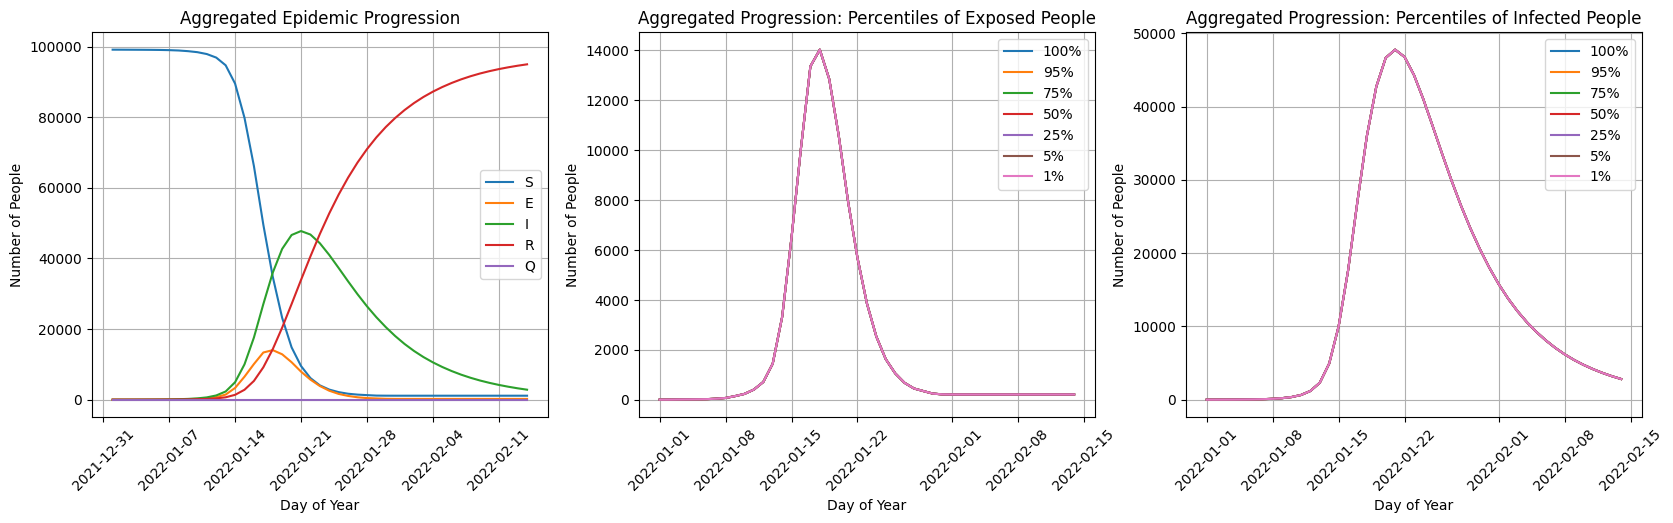

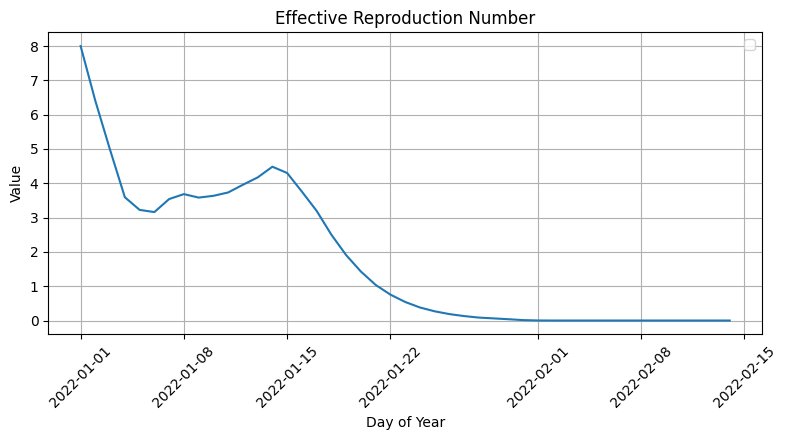

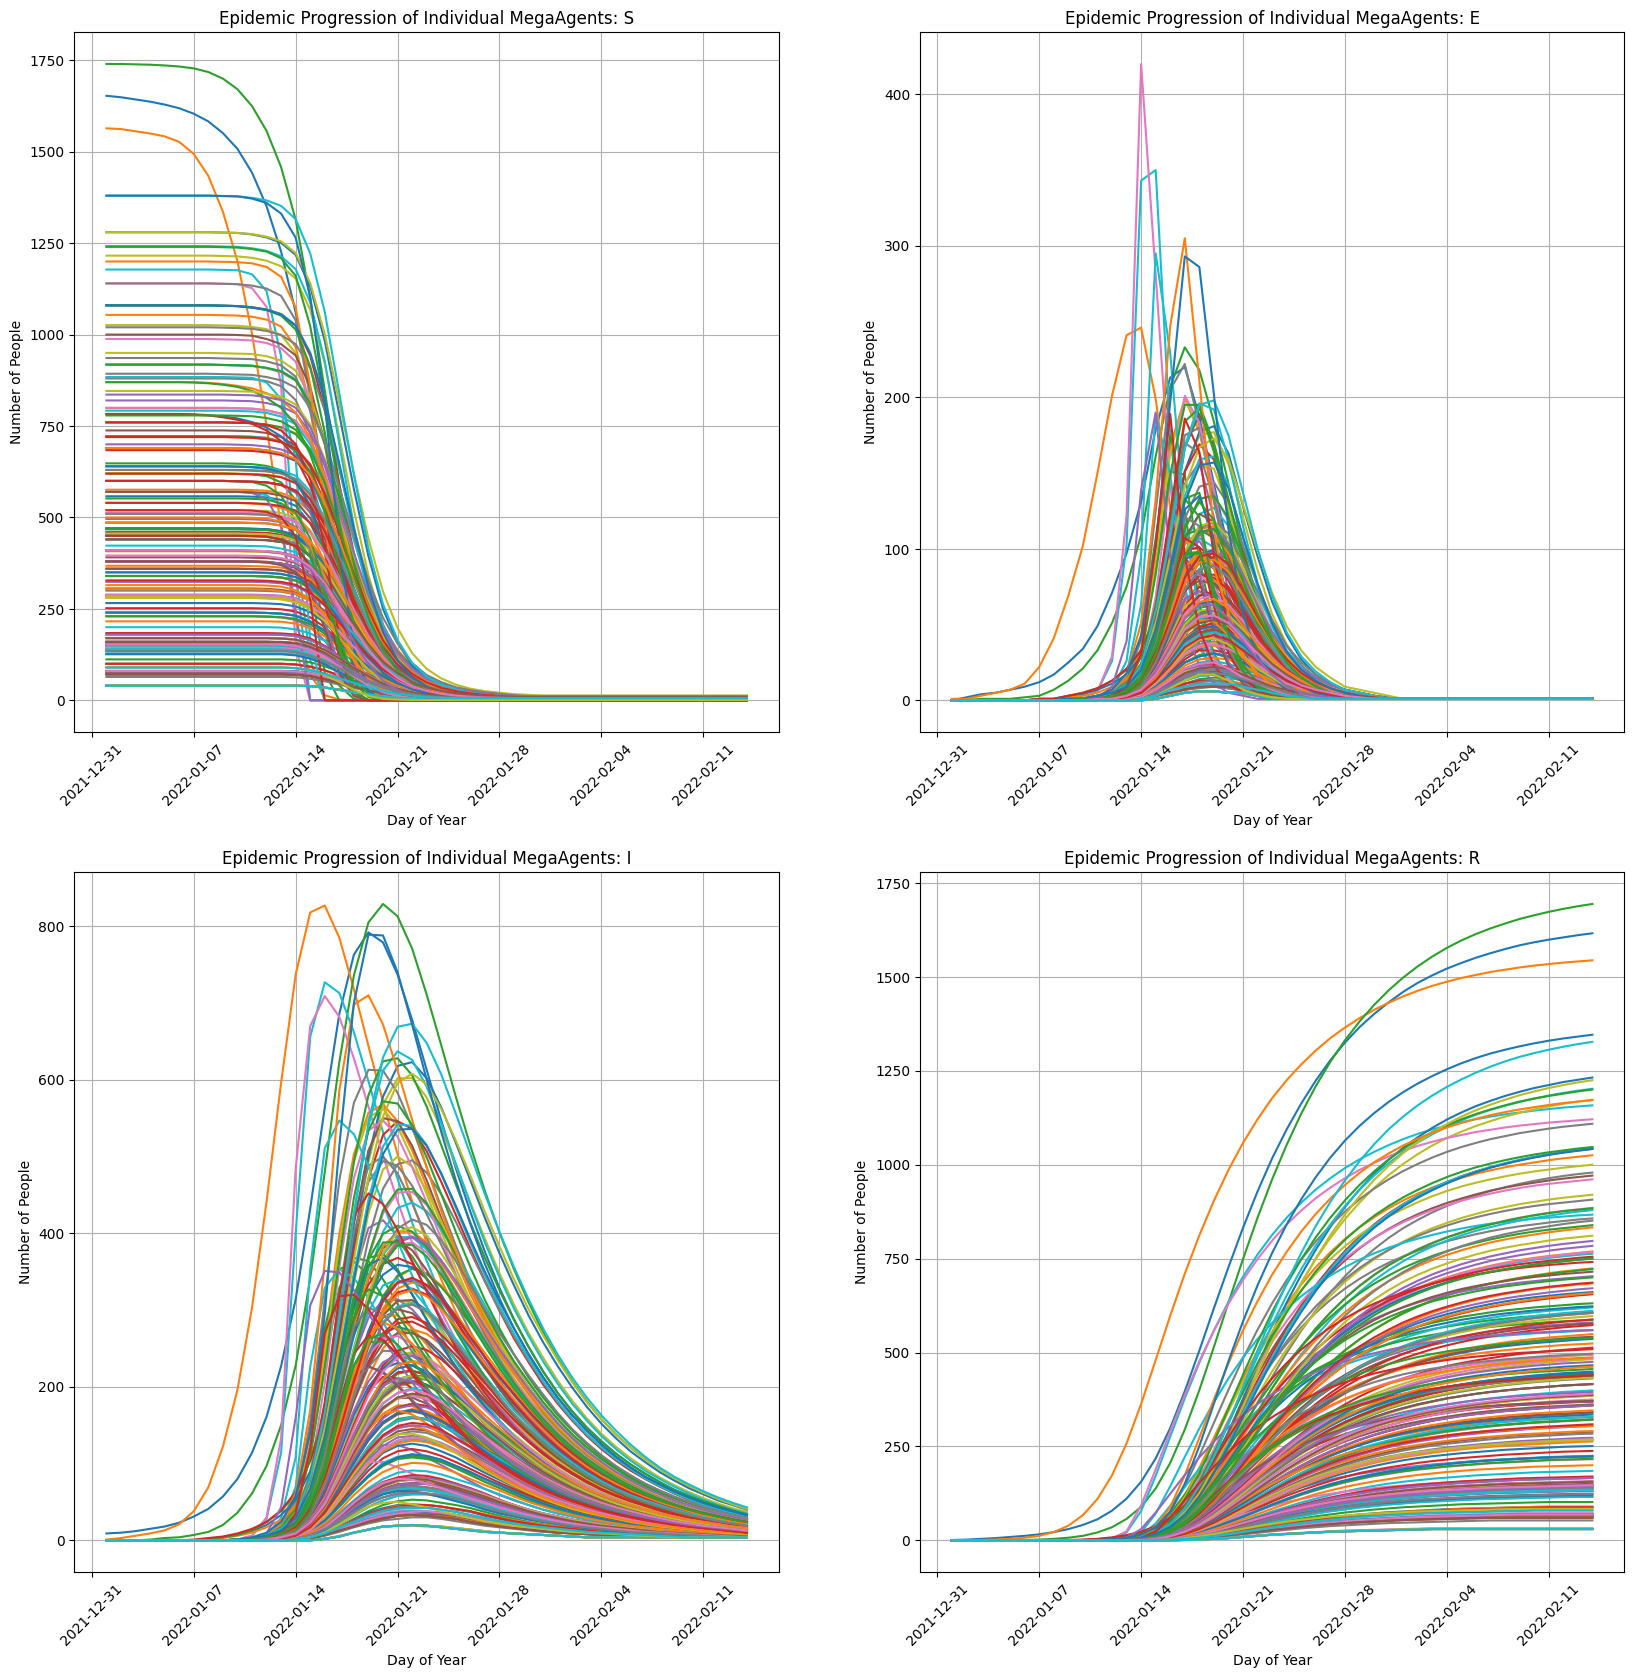

In [12]:
stat.plot_aggregated_progression(parameters)
stat.plot_MegaAgents_progressions()

In [13]:
stat.Reff_agg

{datetime.datetime(2022, 1, 1, 0, 0): [7.999999936000001],
 datetime.datetime(2022, 1, 2, 0, 0): [6.39999998976],
 datetime.datetime(2022, 1, 3, 0, 0): [4.970873783319068],
 datetime.datetime(2022, 1, 4, 0, 0): [3.5929824548493983],
 datetime.datetime(2022, 1, 5, 0, 0): [3.2246527575095216],
 datetime.datetime(2022, 1, 6, 0, 0): [3.1614085861135552],
 datetime.datetime(2022, 1, 7, 0, 0): [3.540495417536112],
 datetime.datetime(2022, 1, 8, 0, 0): [3.68462618744964],
 datetime.datetime(2022, 1, 9, 0, 0): [3.583461597221686],
 datetime.datetime(2022, 1, 10, 0, 0): [3.6345528205663755],
 datetime.datetime(2022, 1, 11, 0, 0): [3.732646055293862],
 datetime.datetime(2022, 1, 12, 0, 0): [3.957191987321915],
 datetime.datetime(2022, 1, 13, 0, 0): [4.170857886968636],
 datetime.datetime(2022, 1, 14, 0, 0): [4.48323179041784],
 datetime.datetime(2022, 1, 15, 0, 0): [4.300040269979105],
 datetime.datetime(2022, 1, 16, 0, 0): [3.7573800927993513],
 datetime.datetime(2022, 1, 17, 0, 0): [3.19607363

# Basic Simulation

In [14]:
# %%time

# # specify how many times you wanna run simulation
# repetitions = 1
# initial_exposed_count = 10
# # discount percentage of hazard brought by an asymptomatic individual
# asym_hazard_multiplier = 0.5
# parameters = Parameters(repetitions, initial_exposed_count, asym_hazard_multiplier)
# parameters.infection_duration = VariedInfectionDurationResponse(rate_from_S_to_E=2,
#                                                              rate_from_E_to_I=1/2, 
#                                                              rate_from_asymI_to_R=1/4, 
#                                                              rate_from_symI_to_R=1/4, 
#                                                              asym_fraction=0, 
#                                                              asym_hazard_multiplier=asym_hazard_multiplier)


# # Create simulation_period_basic_info object
# simulation_period_basic_info = SimulationPeriodBasicInfo(dates,
#                                                       facility_date_time_step_urbano_agent_dic,
#                                                       urbano_agent_date_time_step_facility_dic,
#                                                       urbano_agents_travelers_mapping,
#                                                       traveler_urbano_agent_mapping,
#                                                       time_use_baseline_dict,
#                                                       county_mobility_changes_dict,
#                                                       stationary_distributions,
#                                                       facility_to_index)


# simulation = Simulation(dates, 
#                      simulation_period_basic_info, 
#                      parameters, 
#                      simulation_period_basic_info.AllFacilityNames)

# simulation.run()

# Testing & Contact Tracing & Quarantine

In [15]:
# %%time

# #with cProfile.Profile() as pr: 

# # specify how many times you wanna run simulation
# repetitions = 1
# initial_exposed_count = 10
# # discount percentage of hazard brought by an asymptomatic individual
# asym_hazard_multiplier = 0.5
# parameters = Parameters(repetitions, initial_exposed_count, asym_hazard_multiplier)
# parameters.infection_duration = VariedInfectionDurationResponse(rate_from_S_to_E=2,
#                                                              rate_from_E_to_I=1/2, 
#                                                              rate_from_asymI_to_R=1/4, 
#                                                              rate_from_symI_to_R=1/4, 
#                                                              asym_fraction=0, 
#                                                              asym_hazard_multiplier=asym_hazard_multiplier)


# # Create simulation_period_basic_info object
# simulation_period_basic_info = SimulationPeriodBasicInfo(dates,
#                                                       facility_date_time_step_urbano_agent_dic,
#                                                       urbano_agent_date_time_step_facility_dic,
#                                                       urbano_agents_travelers_mapping,
#                                                       traveler_urbano_agent_mapping,
#                                                       time_use_baseline_dict,
#                                                       county_mobility_changes_dict,
#                                                       stationary_distributions,
#                                                       facility_to_index)


# simulation = Simulation(dates, 
#                      simulation_period_basic_info, 
#                      parameters, 
#                      simulation_period_basic_info.AllFacilityNames)


# # enable this block if conduct testing
# parameters.probs_to_be_tested = {"S":0.1,"E":0.4,"Is":0.8,"Ia":0.4,"R":0.1} 
# parameters.test_accuracy_rate = 0.8
# parameters.prob_of_self_report = 0.2
# parameters.quarantine_prob = 0.05
# parameters.conduct_testing = GeneralTesting(parameters.probs_to_be_tested, 
#                                          parameters.test_accuracy_rate,
#                                          parameters.prob_of_self_report)

# simulation.run()

In [16]:
# st = pstats.Stats(pr)
# st.sort_stats(pstats.SortKey.TIME)
# st.print_stats()